In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr
import sqlite3

c:\Users\vijib\projects\llm_eng_manual\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4.1-mini"
openai = OpenAI()

DB = "prices.db"

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [24]:
prices = [
    ("paris", 200),
    ("london", 500),
    ("India", 1000)
]

with sqlite3.connect(DB) as conn:
  cursor = conn.cursor()
  cursor.executemany('INSERT into prices(city,prices) VALUES (?,?)',prices)

In [25]:
def get_ticket_price(city):
  print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)

  with sqlite3.connect(DB) as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT prices FROM prices WHERE city = ?', (city.lower(),))
    result = cursor.fetchone()
    return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"
  
    


In [26]:
get_ticket_price("Paris")

DATABASE TOOL CALLED: Getting price for Paris


'Ticket price to Paris is $200'

In [27]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}
tools = [{"type": "function", "function": price_function}]
tools

[{'type': 'function',
  'function': {'name': 'get_ticket_price',
   'description': 'Get the price of a return ticket to the destination city.',
   'parameters': {'type': 'object',
    'properties': {'destination_city': {'type': 'string',
      'description': 'The city that the customer wants to travel to'}},
    'required': ['destination_city'],
    'additionalProperties': False}}}]

In [28]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [29]:
def artist(city):
  image_response = openai.images.generate(
    model="dall-e-3",
    prompt = f"show the tourist spots and everything about {city}",
    size="1024x1024",
    n=1,
    response_format ="b64_json"
  )
  image_base64 = image_response.data[0].b64_json
  image_data = base64.b64decode(image_base64)
  return Image.open(BytesIO(image_data))
  

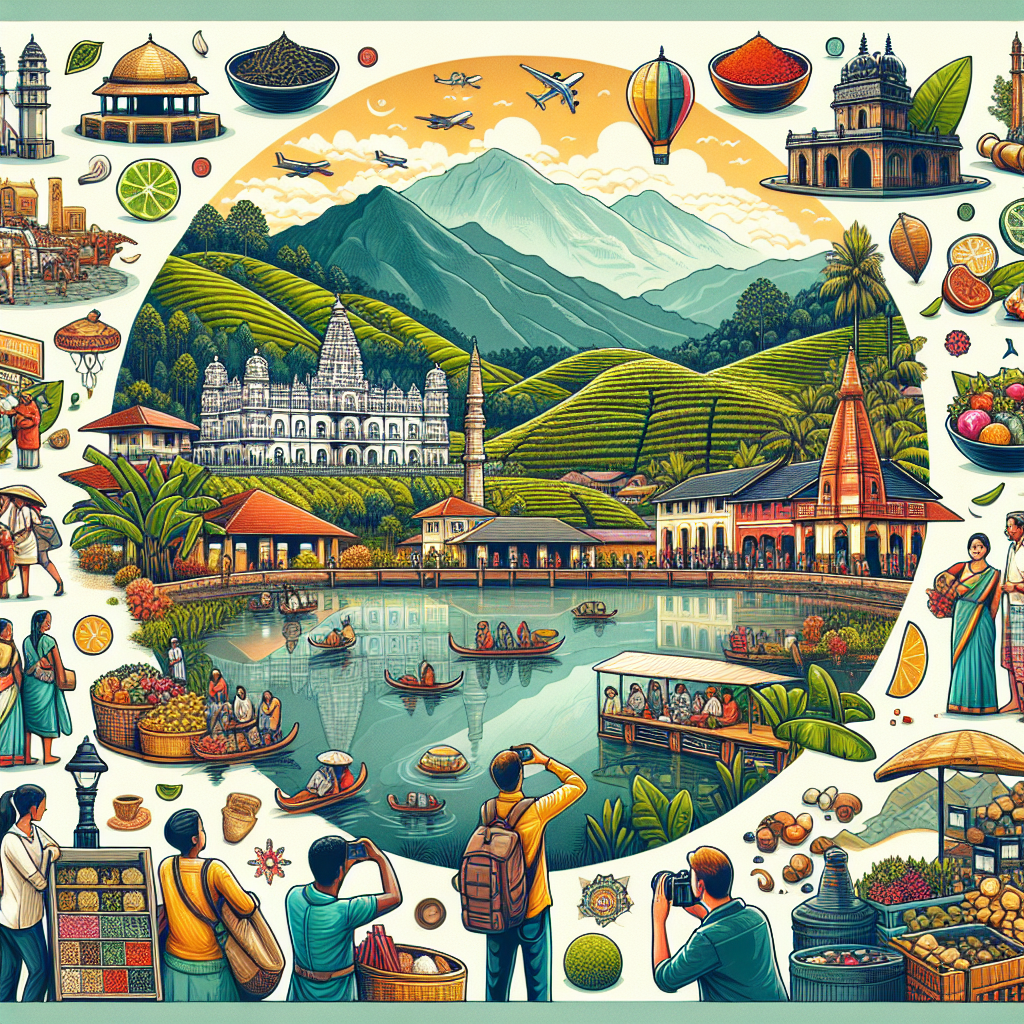

In [30]:
image = artist("Bodinayakanur")
display(image)

In [31]:
def talker(message):
  response = openai.audio.speech.create(
    model="gpt-4o-mini-tts",
    voice="onyx",
    input=message
  )
  return response.content


In [32]:
def handle_tool_calls_and_return_cities(message):
  responses = []
  cities =[]

  for tool_call in message.tool_calls:
    if tool_call.function.name == "get_ticket_price":
      arguments = json.loads(tool_call.function.arguments)
      city = arguments.get('destination_city')
      cities.append(city)
      prices_details = get_ticket_price(city)

      responses.append({
        "role":'tool',
        "content":prices_details,
        "tool_call_id":tool_call.id
      })
  return responses,cities



In [33]:
def chat(history):
  history = [{"role":h["role"],"content":h["content"]} for h in history]
  messages = [{"role": "system", "content": system_message}] + history
  response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
  cities = []
  image = None
  
  while response.choices[0].finish_reason =="tool_calls":
    message = response.choices[0].message
    responses,cities = handle_tool_calls_and_return_cities(message)
    messages.append(message)
    messages.extend(responses)
    response = openai.chat.completions.create(model=MODEL,messages=messages,tools=tools)

  reply = response.choices[0].message.content
  history += [{'role':'assistant','content':reply}]

  voice = talker(reply)

  if cities:
    image = artist(cities[0])
  
  return history,voice,image

In [34]:
def put_message_in_chatbot(message,history):
  return "",history+[{'role':'user','content':message}]

with gr.Blocks() as ui:
  with gr.Row():
    chatbot = gr.Chatbot(height=500)
    image_output = gr.Image(height=500)
  with gr.Row():
    audio_output = gr.Audio(autoplay=True)
  with gr.Row():
    message= gr.Textbox(label="Chat with our AI assistant: ")
  message.submit(put_message_in_chatbot, inputs=[message, chatbot], outputs=[message, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


DATABASE TOOL CALLED: Getting price for madurai


Exception in callback _ProactorBasePipeTransport._call_connection_lost(None)
handle: <Handle _ProactorBasePipeTransport._call_connection_lost(None)>
Traceback (most recent call last):
  File "C:\Python312\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Python312\Lib\asyncio\proactor_events.py", line 165, in _call_connection_lost
    self._sock.shutdown(socket.SHUT_RDWR)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
